In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [2]:
data = pd.read_csv('data.csv')
data


,steps_during_morning,steps_during_afternoon,steps_during_evening,steps_during_bedtime,steps_during_morning_ndays_mean,steps_during_morning_ndays_stdev,steps_during_morning_ndays_gradient,steps_during_afternoon_ndays_mean,steps_during_afternoon_ndays_stdev,steps_during_afternoon_ndays_gradient,...,mesor_ndays_stdev,goodness_of_fit_ndays_mean,goodness_of_fit_ndays_stdev,goodness_of_fit_ndays_gradient,amplitude,mesor,acrophase,goodness_of_fit,timestamp,patient_id
0,46.0,4271.0,3886.0,238.0,2407.000,1517.620,1359.000,6049.67,4045.350,4024.0000,...,1.809390,0.468774,0.092405,0.028774,16.55450,75.8027,13.51340,0.636873,2015-08-30,0
1,8975.0,4294.0,1209.0,238.0,7144.570,2499.000,650.500,7533.57,3439.870,-463.6070,...,2.250650,0.615644,0.048942,-0.012300,13.46240,78.3996,13.83120,0.473510,2015-10-28,0
2,204.0,428.0,835.0,617.0,3088.710,1675.700,524.071,4489.14,2921.570,-81.9286,...,3.913680,0.448787,0.137939,0.052349,11.49640,67.4808,15.19090,0.210210,2015-05-24,0
3,9344.0,2775.0,1269.0,40.0,2935.000,3617.560,5116.000,10290.00,420.021,594.0000,...,2.929610,0.265212,0.179512,-0.004652,10.52350,80.3467,9.45339,0.146700,2018-05-22,0
4,1234.0,3591.0,1269.0,1408.0,590.333,398.801,-95.200,8565.80,3464.000,1714.0000,...,11.264700,0.212145,0.167711,-0.012779,18.17880,85.3592,18.04340,0.263283,2018-06-23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58831,5757.0,5435.0,1269.0,238.0,5063.250,581.089,22.700,8116.50,3000.110,1252.4000,...,2.516985,0.421176,0.130205,0.000042,11.43380,77.8584,16.57375,0.424519,2019-05-09,224
58832,47.0,11497.0,1269.0,1804.0,1063.400,2134.520,23.400,7524.80,3980.090,-1334.8000,...,2.232910,0.338700,0.227881,0.183168,14.74460,85.0776,17.53210,0.401185,2019-04-22,224
58833,5302.0,11782.0,1269.0,238.0,4862.500,921.360,-390.900,6993.00,1623.910,-1107.4000,...,2.516985,0.421176,0.130205,0.000042,11.43380,77.8584,16.57375,0.424519,2019-05-07,224
58834,5807.0,6950.0,1269.0,238.0,5124.000,652.264,456.200,7698.00,3290.230,-55.8000,...,2.516985,0.421176,0.130205,0.000042,11.43380,77.8584,16.57375,0.424519,2019-05-10,224


In [3]:
from sklearn.preprocessing import StandardScaler

# 수치형 컬럼만 선택
numeric_columns = data.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if col != 'patient_id']


# StandardScaler를 사용하여 정규화
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])



print("정규화가 완료되었습니다.")
print("\n처음 5개 행:")
print(data.head())

정규화가 완료되었습니다.

처음 5개 행:
   steps_during_morning  steps_during_afternoon  steps_during_evening  \
0             -0.834113                0.065399              1.008735   
1              3.285922                0.072732             -0.333104   
2             -0.761208               -1.159882             -0.520570   
3              3.456187               -0.411577             -0.303029   
4             -0.285944               -0.151408             -0.303029   

   steps_during_bedtime  steps_during_morning_ndays_mean  \
0             -0.312031                         0.334880   
1             -0.312031                         3.196466   
2              0.185788                         0.746647   
3             -0.572106                         0.653803   
4              1.224771                        -0.762422   

   steps_during_morning_ndays_stdev  steps_during_morning_ndays_gradient  \
0                          0.217531                             2.854541   
1                       

In [4]:
def compute_sleep_quality_score(row):
    efficiency = row["sleep_efficiency"]
    length = row["sleep_length"]
    counts = row["sleep_counts"]
    onset_dev = row["sleep_onset_dev"]

    score = (0.35 * efficiency + 0.2 * length - 0.2 * counts - 0.25 * onset_dev)
    return round(score * 100, 2)  # 0~100점 스케일
data['sleep_quality_score'] = data.apply(compute_sleep_quality_score, axis=1)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_score = scaler.fit_transform(data[['sleep_quality_score']])

data['normalized_score'] = normalized_score*100

data['normalized_score'].describe()

count    58836.000000
mean        76.258302
std          6.756191
min          0.000000
25%         74.392129
50%         78.443102
75%         79.521688
max        100.000000
Name: normalized_score, dtype: float64

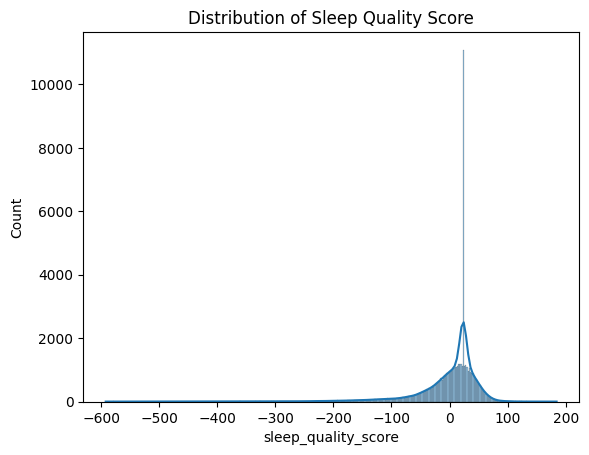

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램으로 분포 보기
sns.histplot(data['sleep_quality_score'], kde=True)
plt.title('Distribution of Sleep Quality Score')
plt.show()


In [7]:
data = data.drop([
    'sleep_length',
    'sleep_efficiency',
    'sleep_onset_dev',
    'sleep_counts'
], axis=1)





In [8]:
# timestamp를 datetime 타입으로 변환 (안 돼 있다면)
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 정렬
data = data.sort_values(by=['patient_id', 'timestamp']).reset_index(drop=True)
print(data)

       steps_during_morning  steps_during_afternoon  steps_during_evening  \
0                 -0.285944                0.857065             -0.688989   
1                  1.359486                0.826138             -0.022832   
2                  1.132467                1.451692             -0.833850   
3                  1.723087                0.643765             -0.469944   
4                  2.453517                2.897925              0.949587   
...                     ...                     ...                   ...   
58831              1.556052                1.544791             -0.303029   
58832              1.801067                0.436523             -0.303029   
58833              1.824138                0.919557             -0.303029   
58834              1.853207                2.693552             -0.232353   
58835              1.318420               -0.683862             -0.303029   

       steps_during_bedtime  steps_during_morning_ndays_mean  \
0          

In [9]:
# 정규화된 데이터 저장
data.to_csv('processed_data.csv', index=False)


In [10]:
from sklearn.model_selection import train_test_split

# 예시: 수면의 질을 예측할 특징(features)와 목표(target)
features = data.drop(columns=['sleep_quality_score', 'normalized_score', 'patient_id', 'timestamp'])
target = data['normalized_score']  # 또는 score_level로 분류 모델 만들 수도 있음

random_seed = 42

# 80% 훈련, 20% 테스트
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=random_seed  # 결과 재현 가능하게
)

In [11]:
# 훈련, 테스트 데이터 저장
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# 첫 번째 Lasso 모델 (alpha=0.01)
lasso = Lasso(alpha=0.1, random_state=random_seed)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
print(f'[alpha=0.1] MSE: {rmse:.3f}, R²: {r2:.3f} MAE: {mae:.3f}')



[alpha=0.1] MSE: 4.893, R²: 0.490 MAE: 3.253


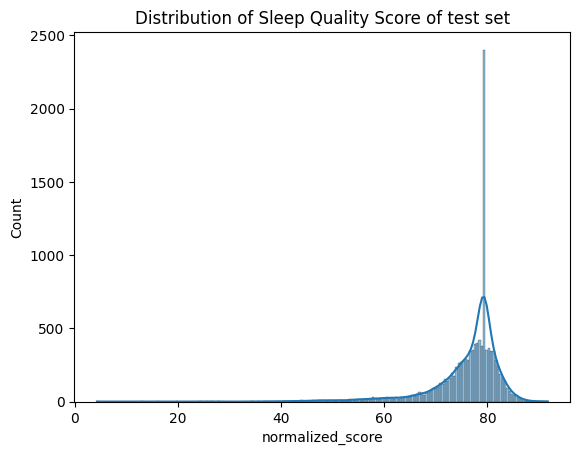

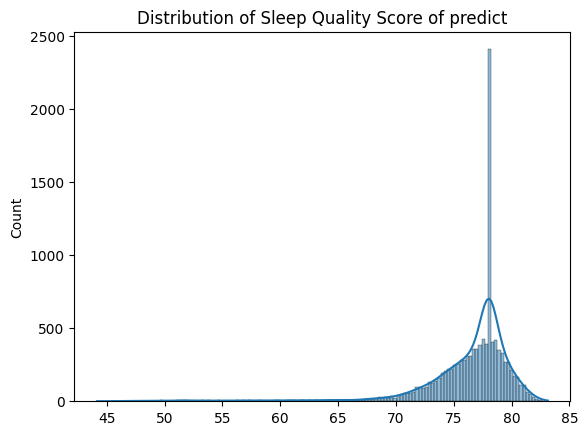

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램으로 분포 보기
sns.histplot(y_test, kde=True)
plt.title('Distribution of Sleep Quality Score of test set')
plt.show()

# 히스토그램으로 분포 보기
sns.histplot(y_pred, kde=True)
plt.title('Distribution of Sleep Quality Score of predict')
plt.show()
